## Lab 06 | Drzewa Decyzyjne - "Programowanie genetyczne"

In [1]:
# Imports

import numpy as np
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import operator
import random
from deap import base, creator, tools, gp, algorithms
import matplotlib.pyplot as plt

In [4]:
X = np.linspace(-10, 10, 100).reshape(-1, 1)
y = X[:, 0]**2 + 3 * X[:, 0] - 1

est = SymbolicRegressor(population_size=500, generations=20,
                        stopping_criteria=0.01, p_crossover=0.7,
                        p_subtree_mutation=0.1, verbose=1,
                        random_state=42)

est.fit(X, y)
y_pred = est.predict(X)

mse = mean_squared_error(y_true=y, y_pred=y_pred)

print(f"Most fitting formula: {est._program}")
print("MSE:", mse)

/home/mikeatta/Documents/git/uni/Sem-VI/Decision-trees/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.66           161635       63          6.59482              N/A     25.50s
   1    35.92          130.285       55          1.48569              N/A     17.53s
   2    51.21          34.6687       51          1.07723              N/A     18.53s
   3    49.74          82.8561       39         0.741255              N/A     16.77s
   4    49.00          25.5635       53         0.255575              N/A     15.44s
   5    51.11          27.1794       49         0.244787              N/A     15.01s
   6    52.24          173.115       75         0.198734              N/A     13.73s
   7    53.01           21.702       71         0.193684              N/A     12.57s
   8    56.91          61.8147       71        0.0863815              N/A  

### Obserwacje

- Ostateczny otrzymany wzór to: ```add(div(mul(X0, X0), add(mul(mul(0.866, X0), div(X0, X0)), X0)), add(-0.903, add(add(mul(X0, X0), add(-0.739, div(X0, 0.815))), add(div(X0, 0.815), sub(-0.237, -0.903)))))```, co po "przekonwertowaniu" wygląda następująco: **f(x) = (x / 1.866) + x \*\* 2 + (2 * x / 0.815) - 0.976**
- add(div(X^2)), add(mul(X * 0.866, div(X, X))), add(-0.963, add(add(X^2)))
- Błąd wzoru: **0.00348320727937794**
- Przy przyjęciu *x == 1*:
  - Oryginalny wzór: f(1) = (1 ** 2) + (3 * 1) - 1 = 3.0
  - Otrzymany: f(1) = (1 / 1.866) + (1 ** 2) + (2 * 1 / 0.815) - 0.976 = 3.013893411
- Otrzymany wzór ma niską wartość błędu średnio kwadratowego oraz otrzymywane z niego wyniki są bliskie oryginalnemu wzorowi, co świadczy o dobrym dopasowaniu.

### Tree implementation in DEAP

In [2]:
# Load the dataset

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Define the main GP functions

# Define the primitive set (float inputs for the dataset labels, int output for the predicted class)
pset = gp.PrimitiveSetTyped("MAIN", [float, float, float, float], int)

# Add primitives
def if_then_else(condition, out1, out2):
    return out1 if condition else out2

def lt(a, b):
    return a < b

pset.addPrimitive(lt, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, int, int], int)

def add(a, b):
    return a + b

def sub(a, b):
    return a - b
    
def mul(a, b):
    return a * b

def protectedDiv(a, b):
    return a / b if b != 0 else 1.0  # Avoids division by zero errors

pset.addPrimitive(add, [float, float], float)
pset.addPrimitive(sub, [float, float], float)
pset.addPrimitive(mul, [float, float], float)
pset.addPrimitive(protectedDiv, [float, float], float)

# Class terminals
pset.addTerminal(0, int)
pset.addTerminal(1, int)
pset.addTerminal(2, int)
pset.addTerminal(True, bool)
pset.addTerminal(False, bool)

# Thresholds
for val in [1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0]:
    pset.addTerminal(val, float)

# Rename the features
pset.renameArguments(ARG0='x0', ARG1='x1', ARG2='x2', ARG3='x3')

In [4]:
# GP setup

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [5]:
# Function for evaluation
def eval_individual(individual):
    func = toolbox.compile(expr=individual)
    predictions = [func(*sample) for sample in X_train]
    return accuracy_score(y_train, predictions),

toolbox.register("evaluate", eval_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=len, max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=len, max_value=10))

# Function for running the algorithm
def run_gp():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1) # Store only the best found result
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    algorithms.eaSimple(population=pop, toolbox=toolbox,
                        cxpb=0.5, mutpb=0.2,
                        ngen=30, stats=stats,
                        halloffame=hof, verbose=True)

    return hof[0]

In [6]:
# Running the GP program

# Get the best individual
best = run_gp()

# Test the best individual
best_func = toolbox.compile(expr=best)
test_preds = [best_func(*x) for x in X_test]
accuracy_gp = accuracy_score(y_test, test_preds)
print(f"Best GP algorithm test accuracy: {accuracy_gp}")

# Print best individual tree
print("Best Tree 'Formula':\n", best)

gen	nevals	avg     	max  
0  	300   	0.333389	0.675
1  	196   	0.351111	0.675
2  	175   	0.36175 	0.675
3  	177   	0.393639	0.675
4  	167   	0.444222	0.675
5  	179   	0.507167	0.675
6  	197   	0.561139	0.675
7  	159   	0.603583	0.675
8  	189   	0.613611	0.675
9  	180   	0.622806	0.675
10 	177   	0.626917	0.675
11 	202   	0.602111	0.675
12 	190   	0.616333	0.675
13 	166   	0.627056	0.675
14 	180   	0.635694	0.675
15 	169   	0.630417	0.675
16 	176   	0.626556	0.675
17 	180   	0.625722	0.675
18 	183   	0.621417	0.675
19 	175   	0.633389	0.675
20 	175   	0.635222	0.675
21 	194   	0.636417	0.675
22 	171   	0.636778	0.675
23 	174   	0.635028	0.675
24 	162   	0.626778	0.675
25 	174   	0.6365  	0.675
26 	176   	0.63675 	0.675
27 	160   	0.62575 	0.675
28 	170   	0.629222	0.675
29 	162   	0.632694	0.675
30 	179   	0.6305  	0.675
Best GP algorithm test accuracy: 0.6333333333333333
Best Tree 'Formula':
 if_then_else(lt(x2, x1), lt(7.0, x2), lt(x3, 7.0))


### Original ML Tree comparison

In [7]:
# Train and evaluate a Tree model

# Use similar parameters to the ones found in the last lab class to prevent overfitting and obtain a more genuine model score
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=10, random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_tree)
precision = precision_score(y_true=y_test, y_pred=y_pred_tree, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred_tree, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred_tree, average="weighted")

print(f"Tree Accuracy: {accuracy}")
print(f"Tree Precision: {precision}")
print(f"Tree Recall: {recall}")
print(f"Tree F1: {f1}")

Tree Accuracy: 0.9666666666666667
Tree Precision: 0.9694444444444444
Tree Recall: 0.9666666666666667
Tree F1: 0.9664109121909632


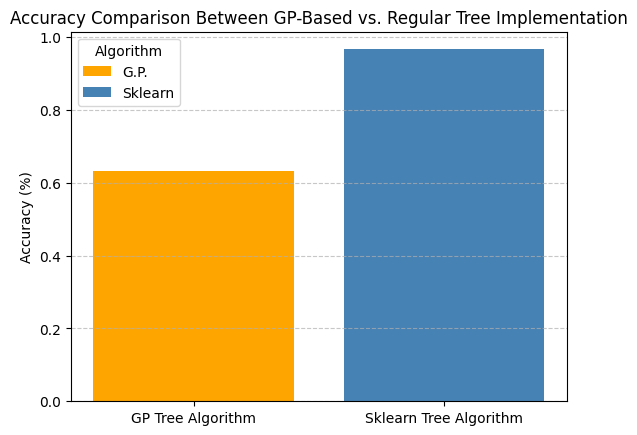

In [8]:
# Plot the resulting accuracy

fig, ax = plt.subplots()

accuracy_descriptions = ["GP Tree Algorithm", "Sklearn Tree Algorithm"]
accuracies = [accuracy_gp, accuracy]
bar_labels = ["G.P.", "Sklearn"]
bar_colors = ["orange", "steelblue"]

ax.bar(accuracy_descriptions, accuracies, label=bar_labels, color=bar_colors)

ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy Comparison Between GP-Based vs. Regular Tree Implementation")
ax.legend(title="Algorithm")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

### Obserwacje i porównanie

- Model _DecisionTreeClassifier_ z Scikit learn poradził sobie z problemem klasyfikacji lepiej niż zbudowany algorytm drzewa biblioteki DEAP.
- W GP, model nie uczy się bezpośrednio przez optymalizację parametrów na zbiorze danych, jak klasyczne algorytmy, lecz ewoluuje struktury drzew poprzez losowe generowanie, ocenę skuteczności i selekcję. Z tego powodu, wykorzystanie GP zajmuje więcej czasu i często wymaga większej liczby pokoleń oraz większych populacji, aby osiągnąć dobre rezultaty.
- Struktura drzewa z biblioteki Scikit learn została już wcześniej starannie zoptymalizowana i usprawniona, co sprawia, że nawet na podstawowych parametrach modele są w stanie osiągnąć zadowalające wyniki.
- Istnieje prawdopodobieństwo, że po odpowiednim dostrojeniu parametrów drzewa GP, będzie ono w stanie dorównać drzewom z algorytmów ML, ale nie jest to pewne, ponieważ struktura algorytmu predykcji w GP opiera się bardziej na niskopoziomowej matematyce i sprawdzaniu warunków, niż uczeniu się z dostępnych danych, w taki sposób, jak jest to robione w przypadku klasycznych modeli drzew.